In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import asapy
import numpy as np
from time import time

# Cenário: Demonstração de Navegação com Aeronave de Caça

### Descrição Geral:
Este cenário descreve um voo de navegação realizado por uma aeronave de caça, enfocando a execução de manobras em diferentes altitudes e velocidades. A navegação abrange uma variação de altitude entre Flight Level (FL) 100 e FL 350, bem como uma variação de velocidade entre 350 knots e 550 knots. Durante este voo, no terceiro ponto da rota, a aeronave realizará uma manobra de espera em torno de um ponto específico (**Hold**) durante 10 minutos, integrando-a ao padrão de voo.

<img src='./data/nav_demo.gif' width='500' height='500'>

#### Carregando Dados das Simulações

Nesta célula, estamos carregando dados de diferentes simulações a partir de arquivos CSV. Para cada cenário, existem dois tipos de arquivos:

1. Arquivos `*_aliases.csv`: Estes contêm as entradas (ou parâmetros) para cada simulação.

2. Arquivos `*_output.csv`: Estes contêm os resultados das simulações. 

Os dados são lidos e carregados em DataFrames do pandas para análise e processamento subsequentes.


In [2]:
x = pd.read_csv('./data/nav_demo_aliases.csv')
y = pd.read_csv('./data/nav_demo_output.csv')

In [3]:
preprocessing  = asapy.Preprocessing()

x = preprocessing.aliases(x)
y = preprocessing.team_metrics(y)

In [4]:
df_nav = pd.merge(x, y[['fuel_consumed']], left_index=True, right_index=True)

In [5]:
sample_nav = df_nav.sample(10)
df_nav = df_nav.loc[~df_nav.index.isin(sample_nav.index)]

In [6]:
df_nav.head(5)

,speed,altitude,fuel_consumed
experiment,,,
0,485.10,13339.30,1460.593196
1,518.46,34516.34,883.070714
2,501.61,23487.75,1063.105283
3,525.65,16748.43,1400.689116
4,438.32,21489.87,1051.047824


## EXPERIMENTO 1: Previsão do Consumo de Combustível na rota específica

### Objetivo do Experimento:
Este experimento visa investigar a relação entre o tempo de voo (`time_of_flight_blue`) e o consumo de combustível (`fuel_consumed_blue`) em um cenário de simulação de voo. O objetivo principal é entender se existe uma correlação direta entre essas duas variáveis, ou seja, se um aumento no tempo de voo resulta consistentemente em um maior consumo de combustível.

### Metodologia:
- Dados Utilizados: Serão analisados dados de **4000** simulações de voo, onde `time_of_flight_blue` representa a duração total do voo (em segundos) e `fuel_consumed_blue` indica a quantidade de combustível consumida (em libras).
- Análise Estatística: Aplicar métodos estatísticos para avaliar a relação entre as duas variáveis. Isso inclue a realização de uma análise de regressão linear, cálculo do coeficiente de correlação, ou outros métodos estatísticos relevantes.
- Visualização de Dados: Utilizar gráficos (como gráficos de dispersão) para visualizar a relação entre tempo de voo e consumo de combustível, facilitando a interpretação dos resultados.

### Hipóteses:
A hipótese principal é que existe uma correlação positiva entre o tempo de voo e o consumo de combustível, significando que quanto maior o tempo de voo, maior o consumo de combustível.

### Resultados Esperados:
Os resultados podem ser úteis para o planejamento de rotas aéreas mais eficientes em termos de consumo de combustível, e para aprimorar modelos de previsão de consumo de combustível em simulações aeronáuticas.

### Aplicações Potenciais:
Os resultados podem ser úteis para treinamento em simuladores de voo, planejamento de rotas aéreas mais eficientes em termos de combustível, e para aprimorar modelos de previsão de consumo de combustível em simulações aeronáuticas.

#### Rede Neural

In [7]:
start_time_1 = time()

In [8]:
nn_nav = asapy.NeuralNetwork(target="fuel_consumed", name='demo_nn_nav', seed=25)

In [9]:
nn_nav.build(
    df_nav,
    task="regression",
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    patience_reduceLR = 4,
    metrics=['rmse']
)


                Task: regression

                Total of registers: 3990
                Total of valid registers: 3990
                Total of invalid registers: 0

                Total of training registers: 2792
                Total of validation registers: 599
                Total of test registers: 599

                Features before preprocessing: 2
                Features after preprocessing: 2

                Numerical Features: ['speed', 'altitude']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['fuel_consumed']
            


In [10]:
nn_nav.hyperparameter_optimization(
    n_trials=18,
    num_folds=4,
    info=True,
    search_space_dropout = [0.0, 0.5],
    search_space_layers = [2, 3, 4],
    search_space_batch_size = [32, 64, 128],
    search_space_optimizer = ['Adam']
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


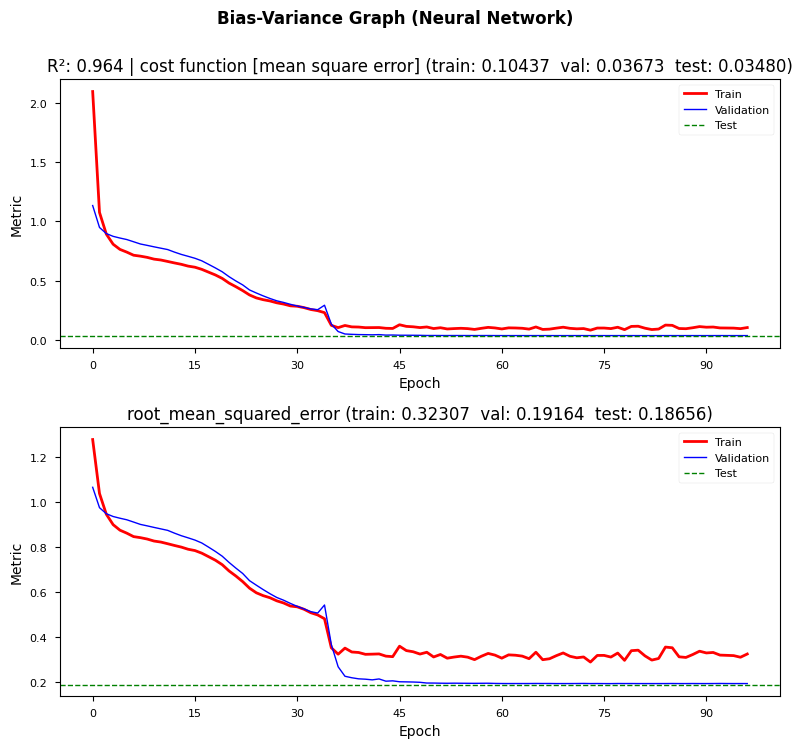

In [11]:
nn_nav.fit(return_history=False, graph=True, graph_save_extension='eps', verbose=0)

In [12]:
end_time_1 = time()

In [13]:
start_time_2 = time()

In [14]:
pred_nn_nav = nn_nav.predict(sample_nav, verbose=0)

Inference time: 53.63 milliseconds (10 register(s))


In [15]:
pred_nn_nav

,speed,altitude,fuel_consumed,fuel_consumed (NN prediction)
experiment,,,,
2015,352.43,19110.39,1103.915773,1019.411377
1480,350.66,19152.46,1115.599070,1017.364746
411,546.05,30595.64,945.536189,977.627991
244,505.22,23646.51,1065.373618,1061.199219
3572,465.19,12089.28,1431.657443,1411.376221
763,483.01,19106.04,1181.480430,1179.544800
1693,375.81,34581.08,1130.032181,1044.911255
1297,406.98,28644.30,968.901016,941.364502
2355,459.91,26574.33,957.232039,978.243774


In [16]:
end_time_2 = time()

In [17]:
print(f"Tempo de Treinamento: {end_time_1 - start_time_1}")

Tempo de Treinamento: 1189.263240814209


In [18]:
print(f"Tempo de Inferência: {end_time_2 - start_time_2}")

Tempo de Inferência: 0.08904409408569336


#### XG Boost

In [19]:
start_time_3 = time()

In [20]:
xgb_nav = asapy.XgBoost(target="fuel_consumed", name='demo_xgb_nav', seed=25)

In [21]:
xgb_nav.build(
    df_nav,
    task="regression",
    num_folds=5,
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    metrics=['mse']
)


                Task: regression

                Total of registers: 3990
                Total of valid registers: 3990
                Total of invalid registers: 0

                Total of training registers: 2792
                Total of validation registers: 599
                Total of test registers: 599

                Features before preprocessing: 2
                Features after preprocessing: 2

                Numerical Features: ['speed', 'altitude']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['fuel_consumed']
            


In [22]:
xgb_nav.hyperparameter_optimization(
    n_trials=10,
    num_folds = 5, 
    info=True,
    search_space_tree_method = ['auto'],
    search_space_booster = ['gbtree', 'gblinear', 'dart'],
    search_space_learning_rate = [0.3],
    search_space_min_split_loss = [0],
    search_space_max_depth = [6],
    search_space_min_child_weight = [1],
    search_space_max_delta_step = [0],
    search_space_subsample = [1],
    search_space_sampling_method = ['uniform'],
    search_space_colsample_bytree = [1],
    search_space_colsample_bylevel = [1],
    search_space_colsample_bynode = [1],
    search_space_reg_lambda = [1],
    search_space_reg_alpha = [0],
    search_space_scale_pos_weight = [1],
    search_space_grow_policy = ['depthwise'],
    search_space_max_leaves = [0],
    search_space_max_bin = [256],
    search_space_num_parallel_tree = [1]
)

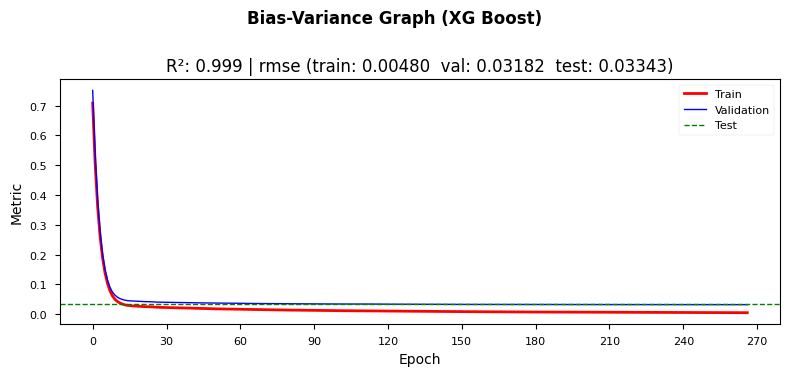

In [23]:
history_xgb_nav = xgb_nav.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [24]:
end_time_3 = time()

In [25]:
start_time_4 = time()

In [26]:
pred_xgb_nav = xgb_nav.predict(sample_nav)

Inference time: 56.84 milliseconds (10 register(s))


In [27]:
pred_xgb_nav

,speed,altitude,fuel_consumed,fuel_consumed (XGB prediction)
experiment,,,,
2015,352.43,19110.39,1103.915773,1095.026855
1480,350.66,19152.46,1115.599070,1113.651611
411,546.05,30595.64,945.536189,944.776062
244,505.22,23646.51,1065.373618,1075.479370
3572,465.19,12089.28,1431.657443,1437.838623
763,483.01,19106.04,1181.480430,1183.555298
1693,375.81,34581.08,1130.032181,1130.304688
1297,406.98,28644.30,968.901016,964.688416
2355,459.91,26574.33,957.232039,957.832397


In [28]:
end_time_4 = time()

In [29]:
print(f"Tempo de Treinamento: {end_time_3 - start_time_3}")

Tempo de Treinamento: 225.53127121925354


In [30]:
print(f"Tempo de Inferência: {end_time_4 - start_time_4}")

Tempo de Inferência: 0.08817481994628906


## EXPERIMENTO 2: Previsão do Consumo de Combustível na rota específica

### Objetivo do Experimento:
Este experimento visa investigar a relação entre o tempo de voo (`time_of_flight_blue`) e o consumo de combustível (`fuel_consumed_blue`) em um cenário de simulação de voo. O objetivo principal é entender se existe uma correlação direta entre essas duas variáveis, ou seja, se um aumento no tempo de voo resulta consistentemente em um maior consumo de combustível.

### Metodologia:
- Dados Utilizados: Serão analisados dados de **4000** simulações de voo, onde `time_of_flight_blue` representa a duração total do voo (em segundos) e `fuel_consumed_blue` indica a quantidade de combustível consumida (em libras).
- Análise Estatística: Aplicar métodos estatísticos para avaliar a relação entre as duas variáveis. Isso inclue a realização de uma análise de regressão linear, cálculo do coeficiente de correlação, ou outros métodos estatísticos relevantes.
- Visualização de Dados: Utilizar gráficos (como gráficos de dispersão) para visualizar a relação entre tempo de voo e consumo de combustível, facilitando a interpretação dos resultados.

### Hipóteses:
A hipótese principal é que existe uma correlação positiva entre o tempo de voo e o consumo de combustível, significando que quanto maior o tempo de voo, maior o consumo de combustível.

### Resultados Esperados:
Os resultados podem ser úteis para o planejamento de rotas aéreas mais eficientes em termos de consumo de combustível, e para aprimorar modelos de previsão de consumo de combustível em simulações aeronáuticas.

### Aplicações Potenciais:
Os resultados podem ser úteis para treinamento em simuladores de voo, planejamento de rotas aéreas mais eficientes em termos de combustível, e para aprimorar modelos de previsão de consumo de combustível em simulações aeronáuticas.

#### KMeans

In [31]:
start_time_5 = time()

In [32]:
kmeans_nav = asapy.KMeans(name='demo_kmeans_nav', seed=25)

In [33]:
kmeans_nav.build(df_nav, info=True)


                Total of registers: 3990
                Total of valid registers: 3990
                Total of invalid registers: 0

                Total of Features: 3
                Numerical Features: ['speed', 'altitude', 'fuel_consumed']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []
            


In [34]:
kmeans_nav.hyperparameter_optimization(
    n_trials=10,
    info=True,
    search_space_n_clusters=[4],
    search_space_init  = ['k-means++'],
    search_space_n_init = ['auto'],
    search_space_tol = [1e-5, 1e-4, 1e-3],
    search_space_algorithm = ['lloyd', 'elkan']
)

,Trial (nº),Silhouette Score,params_algorithm,params_init,params_n_clusters,params_n_init,params_tol
Ranking,,,,,,,
1º,2,0.394827,elkan,k-means++,4,auto,0.00010
2º,5,0.394827,lloyd,k-means++,4,auto,0.00010
3º,7,0.394827,lloyd,k-means++,4,auto,0.00010
4º,8,0.394827,lloyd,k-means++,4,auto,0.00010
5º,9,0.394827,elkan,k-means++,4,auto,0.00010
6º,0,0.394806,lloyd,k-means++,4,auto,0.00100
7º,1,0.394806,elkan,k-means++,4,auto,0.00100
8º,3,0.394806,elkan,k-means++,4,auto,0.00100
9º,4,0.394806,lloyd,k-means++,4,auto,0.00100


In [35]:
clusters = kmeans_nav.fit(return_cluster=True)

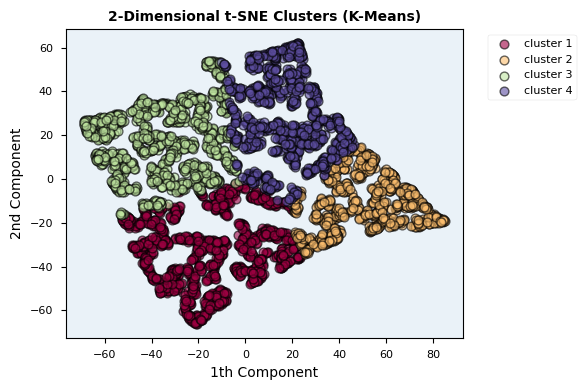

In [36]:
kmeans_nav.predict(projection='2d', graph_save_extension='png')

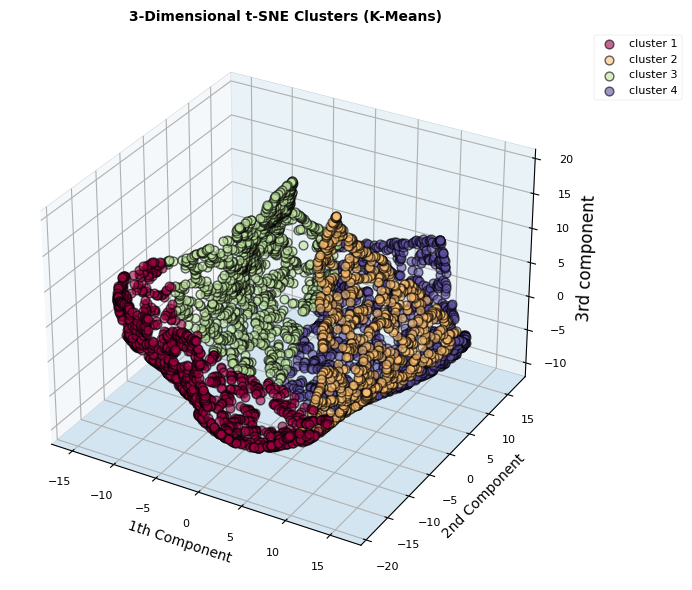

In [37]:
kmeans_nav.predict(projection='3d', graph_save_extension='png')

In [38]:
end_time_5 = time()

In [39]:
print(f"Tempo de Treinamento: {end_time_5 - start_time_5}")

Tempo de Treinamento: 38.3482551574707


## EXPERIMENTO 3: Previsão do Consumo de Combustível na rota específica

### Objetivo do Experimento:
Este experimento visa investigar a relação entre o tempo de voo (`time_of_flight_blue`) e o consumo de combustível (`fuel_consumed_blue`) em um cenário de simulação de voo. O objetivo principal é entender se existe uma correlação direta entre essas duas variáveis, ou seja, se um aumento no tempo de voo resulta consistentemente em um maior consumo de combustível.

### Metodologia:
- Dados Utilizados: Serão analisados dados de **4000** simulações de voo, onde `time_of_flight_blue` representa a duração total do voo (em segundos) e `fuel_consumed_blue` indica a quantidade de combustível consumida (em libras).
- Análise Estatística: Aplicar métodos estatísticos para avaliar a relação entre as duas variáveis. Isso inclue a realização de uma análise de regressão linear, cálculo do coeficiente de correlação, ou outros métodos estatísticos relevantes.
- Visualização de Dados: Utilizar gráficos (como gráficos de dispersão) para visualizar a relação entre tempo de voo e consumo de combustível, facilitando a interpretação dos resultados.

### Hipóteses:
A hipótese principal é que existe uma correlação positiva entre o tempo de voo e o consumo de combustível, significando que quanto maior o tempo de voo, maior o consumo de combustível.

### Resultados Esperados:
Os resultados podem ser úteis para o planejamento de rotas aéreas mais eficientes em termos de consumo de combustível, e para aprimorar modelos de previsão de consumo de combustível em simulações aeronáuticas.

### Aplicações Potenciais:
Os resultados podem ser úteis para treinamento em simuladores de voo, planejamento de rotas aéreas mais eficientes em termos de combustível, e para aprimorar modelos de previsão de consumo de combustível em simulações aeronáuticas.

#### Data leak intencional, com o intuito de criar um Case de classificação. Asuma que a nfomação do cluster seja obtida de observação factual

In [40]:
df_nav_class = df_nav.copy()
df_nav_class['Cluster'] = clusters

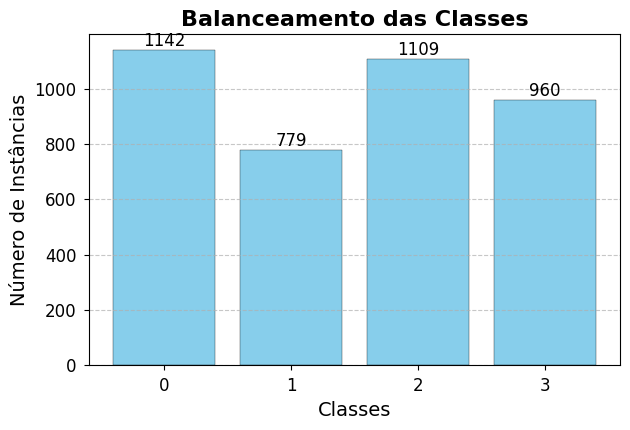

In [41]:
# plt.style.use('seaborn-darkgrid')  # Usa um estilo de fundo do Seaborn
# plt.figure(figsize=(10, 6))  # Tamanho do gráfico

class_counts = df_nav_class['Cluster'].value_counts().sort_index()

bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

plt.title('Balanceamento das Classes', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Instâncias', fontsize=14)

plt.xticks(class_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [42]:
# !pip install imblearn

In [43]:
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
X = df_nav_class.drop('Cluster', axis=1)
y = df_nav_class['Cluster']

X_res, y_res = sm.fit_resample(X, y)

# Se precisar, converta de volta para DataFrame pandas
df_nav_class = pd.DataFrame(X_res, columns=X.columns)
df_nav_class['Cluster'] = y_res

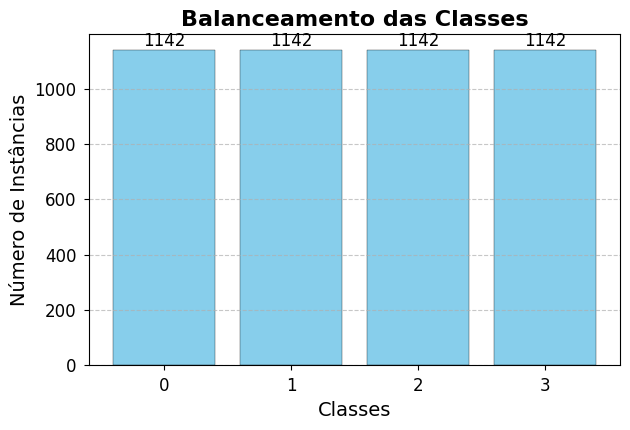

In [44]:
# plt.style.use('seaborn-darkgrid')  # Usa um estilo de fundo do Seaborn
# plt.figure(figsize=(10, 6))  # Tamanho do gráfico

class_counts = df_nav_class['Cluster'].value_counts().sort_index()

bars = plt.bar(class_counts.index, class_counts.values, color='skyblue', edgecolor='black')

plt.title('Balanceamento das Classes', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Número de Instâncias', fontsize=14)

plt.xticks(class_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

In [45]:
sample_nav_class = df_nav_class.sample(10)
df_nav_class = df_nav_class.loc[~df_nav_class.index.isin(sample_nav_class.index)]

#### Rede Neural

In [46]:
start_time_6 = time()

In [47]:
nn_nav_class = asapy.NeuralNetwork(target="Cluster", name='demo_nn_nav_class', seed=25)

In [48]:
nn_nav_class.build(
    df_nav_class,
    task='classification',
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20,
    patience_reduceLR = 4,
    metrics=['auc', 'precision', 'recall', 'accuracy'] 
)


                Task: classification

                Total of registers: 4558
                Total of valid registers: 4558
                Total of invalid registers: 0

                Total of training registers: 3190
                Total of validation registers: 684
                Total of test registers: 684

                Features before preprocessing: 3
                Features after preprocessing: 3

                Numerical Features: ['speed', 'altitude', 'fuel_consumed']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['Cluster']
            	Cardinality (Target): 4


In [49]:
nn_nav_class.hyperparameter_optimization(
    n_trials=10,
    num_folds=5,
    info=True,
    search_space_dropout = [0.0, 0.5],
    search_space_layers = [2, 3, 4],
    search_space_batch_size = [32, 64],
    search_space_optimizer = ['Adam']
)

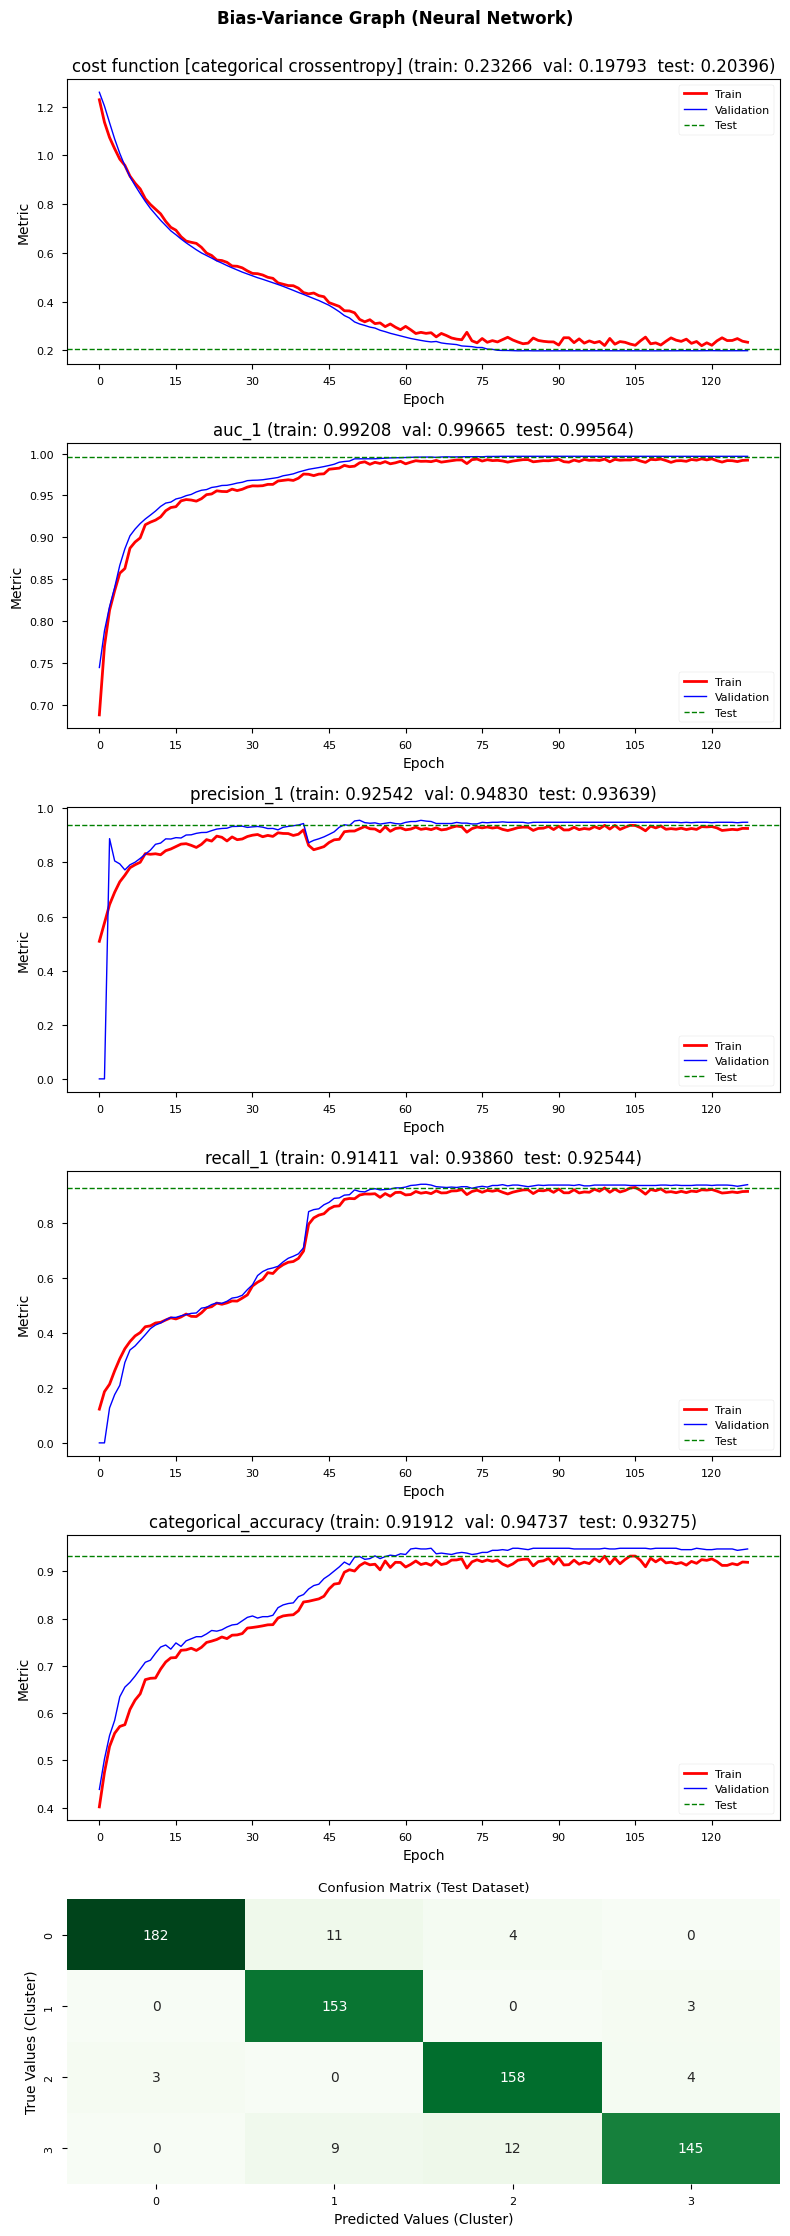

In [50]:
history_nn_nav_class = nn_nav_class.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [51]:
end_time_6 = time()

In [52]:
start_time_7 = time()

In [53]:
pred_nn_nav_class = nn_nav_class.predict(sample_nav_class, verbose=0)

Inference time: 65.78 milliseconds (10 register(s))


In [54]:
pred_nn_nav_class

,speed,altitude,fuel_consumed,Cluster,Cluster (NN prediction)
3639,411.670000,28080.680000,972.996346,2,2
4198,544.145627,20620.097075,1292.045708,1,1
2519,521.910000,21665.630000,1170.045806,0,1
4458,409.656233,13670.833253,1186.518160,3,3
3288,516.770000,20331.680000,1198.833256,1,1
4525,460.320852,20443.699128,1091.702014,3,3
3587,477.830000,13913.280000,1405.449019,1,1
2772,526.370000,14509.020000,1520.112550,1,1
1664,383.960000,25837.580000,988.279091,2,2
2408,385.520000,12365.830000,1126.151862,3,3


In [55]:
end_time_7 = time()

In [56]:
print(f"Tempo de Treinamento: {end_time_6 - start_time_6}")

Tempo de Treinamento: 1079.4771518707275


In [57]:
print(f"Tempo de Inferência: {end_time_7 - start_time_7}")

Tempo de Inferência: 0.09783744812011719


#### XG Boost

In [58]:
start_time_8 = time()

In [59]:
xgb_nav_class = asapy.XgBoost(target="Cluster", name='demo_xgb_nav_class', seed=25)

In [60]:
xgb_nav_class.build(
    df_nav_class,
    task='classification',
    max_cat_nunique = 10,
    split_size = (0.7, 0.15, 0.15),
    info=True,
    patience_early_stopping = 20
)


                Task: classification

                Total of registers: 4558
                Total of valid registers: 4558
                Total of invalid registers: 0

                Total of training registers: 3190
                Total of validation registers: 684
                Total of test registers: 684

                Features before preprocessing: 3
                Features after preprocessing: 3

                Numerical Features: ['speed', 'altitude', 'fuel_consumed']
                Categorical Features: []
                Categorical Features removed due to high cardinality: []

                Target: ['Cluster']
            	Cardinality (Target): 4


In [61]:
xgb_nav_class.hyperparameter_optimization(
    n_trials=10,
    num_folds=5,
    info=True,
    search_space_tree_method = ['auto'],
    search_space_booster = ['gbtree', 'gblinear', 'dart'],
    search_space_learning_rate = [0.2, 0.3],
    search_space_min_split_loss = [0],
    search_space_max_depth = [5, 6, 7],
    search_space_min_child_weight = [1],
    search_space_max_delta_step = [0],
    search_space_subsample = [1],
    search_space_sampling_method = ['uniform'],
    search_space_colsample_bytree = [1],
    search_space_colsample_bylevel = [1],
    search_space_colsample_bynode = [1],
    search_space_reg_lambda = [1],
    search_space_reg_alpha = [0],
    search_space_scale_pos_weight = [1],
    search_space_grow_policy = ['depthwise'],
    search_space_max_leaves = [0],
    search_space_max_bin = [256, 512],
    search_space_num_parallel_tree = [1]
)

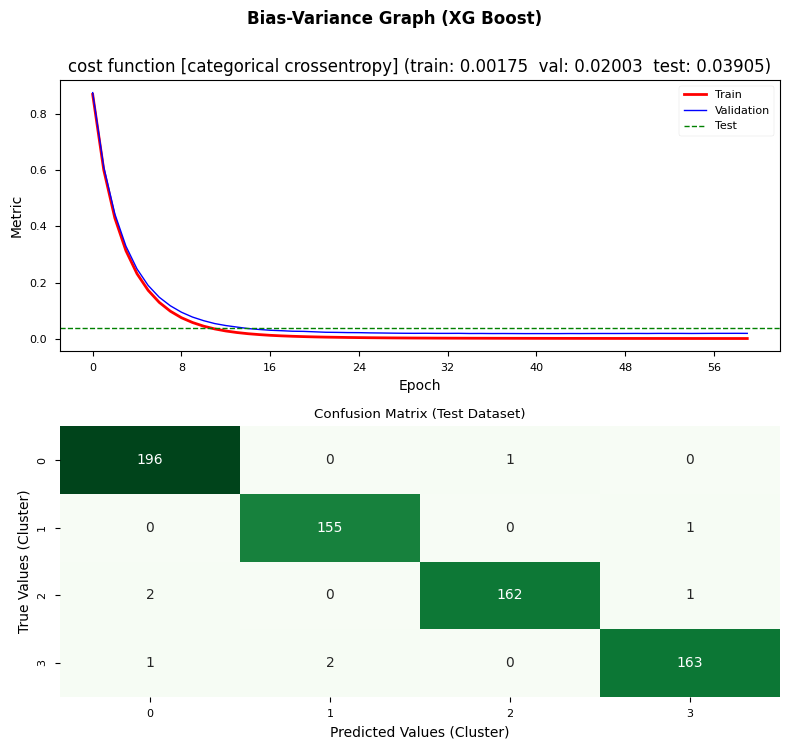

In [62]:
history_xgb_nav_class = xgb_nav_class.fit(return_history=True, graph=True, graph_save_extension='png', verbose=0)

In [63]:
end_time_8 = time()

In [64]:
start_time_9 = time()

In [65]:
pred_xgb_nav_class = xgb_nav_class.predict(sample_nav_class)

Inference time: 4.01 milliseconds (10 register(s))


In [66]:
pred_xgb_nav_class

,speed,altitude,fuel_consumed,Cluster,Cluster (XGB prediction)
3639,411.670000,28080.680000,972.996346,2,2
4198,544.145627,20620.097075,1292.045708,1,1
2519,521.910000,21665.630000,1170.045806,0,0
4458,409.656233,13670.833253,1186.518160,3,3
3288,516.770000,20331.680000,1198.833256,1,1
4525,460.320852,20443.699128,1091.702014,3,3
3587,477.830000,13913.280000,1405.449019,1,1
2772,526.370000,14509.020000,1520.112550,1,1
1664,383.960000,25837.580000,988.279091,2,2
2408,385.520000,12365.830000,1126.151862,3,3


In [67]:
end_time_9 = time()

In [68]:
print(f"Tempo de Treinamento: {end_time_8 - start_time_8}")

Tempo de Treinamento: 200.89446902275085


In [69]:
print(f"Tempo de Inferência: {end_time_9 - start_time_9}")

Tempo de Inferência: 0.03748369216918945
